# Project Exploration
## The Dataset and What we hope to do with it:
- The dataset we are using is the concatenated data of the 2015 Human Development Report, taken from Kaggle and developed by the United Nations.
- This data includes the average, standard deviation, min, and max of all variables that are a float, which is nice for describing it.
- It uses 45 variables that are supposed to describe the development of each of 195 listed countries. 
- A weird and potentially troublesome thing about this is it doesn't include all countries and has some 'countries' that are not always considered countries by definition. We will thus be taking out the 'countries' that are not recognized by the formal United Nations.
- Another issue is that there is a limitation of validity because the numbers are self reported and in some categories absent. We plan to take out some countries for their absence of data (taking out any with more than 10 missing values) and take our results with a grain of salt.

Our problem/goal: We hope to be able to use our model to find the GDI (Gender Development Index) from the HDI (Human Development Index) within the MDI (Multidimensional Poverty Index) of any country with our dataset. 
- We are going to keep the whole concatonated dataset and the MPI dataset seperate because they refer to different countries and we want to make multiple regression models that fit the NaN values between them before combining the dataset.

## Descriptive plots and graphs:

In [713]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import read_csv
import sklearn
import numpy as np
from pprint import pprint
import math 
import locale
from locale import atof
import numpy.random as rn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


locale.setlocale(locale.LC_NUMERIC, '')

gd_data = read_csv("https://www.dropbox.com/s/upot2a908xz26mn/gender_development.csv?dl=1")
gi_data = read_csv("https://www.dropbox.com/s/ensgp6e3chobe5x/gender_inequality.csv?dl=1")
hi_data = read_csv("https://www.dropbox.com/s/3u7udv2hlseddcb/historical_index.csv?dl=1")
ia_data = read_csv("https://www.dropbox.com/s/t7z4t0dj0ik16vc/inequality_adjusted.csv?dl=1")
hd_data = read_csv("https://www.dropbox.com/s/pjijqqsebk9vuwl/human_development.csv?dl=1")
mpi_data = read_csv('https://www.dropbox.com/s/jq78geqaa7qaobs/multidimensional_poverty.csv?dl=1')

In [714]:
whole_data = pd.concat([gd_data, gi_data,hd_data,ia_data,hi_data],axis=1,sort=False, copy = True).drop(['HDI Rank',
       'Human Development Index (HDI)'], axis =1)

In [715]:
whole_data = whole_data.loc[:,~whole_data.columns.duplicated()]

In [716]:
for column in whole_data.columns:
    for row in whole_data.index: 
        if whole_data.loc[row,column] == '..':
            whole_data.loc[row,column]= np.nan
for column in mpi_data.columns:
    for row in mpi_data.index: 
        if mpi_data.loc[row,column] == '..':
            mpi_data.loc[row,column]= np.nan

In [717]:
whole_data.drop(whole_data.index[188:194], axis =0)
whole_data =whole_data.drop(['Income Inequality (Quintile Ratio)','Income Inequality (Palma Rati)', 'Income Inequality (Gini Coefficient)'], axis =1)

In [718]:
mpi_data.head()

,Country,Year and Survey,"Multidimensional Poverty Index (MPI, HDRO)",MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,Afghanistan,2010/2011 M,0.293,58.8,0.353,66.2,"17,116",49.9,45.6,19.2,35.2,35.8,NaN
1,Albania,2008/2009 D,0.005,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,Argentina,2005 N,0.015,3.7,0.011,2.9,"1,438",39.1,38.2,27.8,34.0,NaN,1.4
3,Armenia,2010 D,0.002,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32.0,1.8
4,Azerbaijan,2006 D,0.009,2.4,0.021,5.3,210,38.2,20.0,50.7,29.3,5.3,0.3


In [719]:
for col in whole_data.columns:
    if col != 'Country':
        for i in range(len(whole_data[col])):
            if type(whole_data[col][i]) not in [np.float64, float] and whole_data[col][i] is not None:
                whole_data[col][i] = np.float64(whole_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [720]:
for col in mpi_data.columns:
    if col != 'Country' and col != 'Year and Survey':
        for i in range(len(mpi_data[col])):
            if type(mpi_data[col][i]) not in [np.float64, float] and mpi_data[col][i] is not None:
                mpi_data[col][i] = np.float64(mpi_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Regression Models for Filling Gaps
## Now we need to create regression models to fill in non-existant data points. To do this we must first drop points that have little to no data. 
- We use the loc feature to find all NaN  points. If there are >10 we will delete th erow to protect the integrity of the model. The following must be removed from the data set

- 'Hong Kong, China (SAR)'
- 'Liechtenstein'
- 'Brunei Darussalam' 
- 'Andorra' 
- 'Bahamas'
- 'Antigua and Barbuda'
- 'Palau'
- 'Seychelles' 
- 'Saint Kitts and Nevis'
- 'Grenada'
- 'Bosnia and Herzegovina'
- 'Dominica'
- 'Saint Vincent and the Grenadines'
- 'Turkmenistan'
- 'Gabon'
- 'Viet Nam'
- 'Cabo Verde'
- 'Micronesia (Federated States of)'
- 'Kiribati'
- 'Equatorial Guinea'
- 'Myanmar'
- 'Angola'
- 'Solomon Islands'
- 'Papua New Guinea'
- 'Haiti'
- 'Djibouti'
- 'Guinea-Bissau'
- 'Eritrea'

In [721]:
whole_data = whole_data.drop([whole_data.index[11], whole_data.index[12], whole_data.index[30], whole_data.index[33],
                 whole_data.index[54], whole_data.index[57] ,whole_data.index[59], whole_data.index[63], whole_data.index[76],
                 whole_data.index[78], whole_data.index[86], whole_data.index[93], whole_data.index[97],
                 whole_data.index[108], whole_data.index[109], whole_data.index[117], whole_data.index[121],
                 whole_data.index[122], whole_data.index[137], whole_data.index[136], whole_data.index[147],
                 whole_data.index[148], whole_data.index[156], whole_data.index[157], whole_data.index[162],
                 whole_data.index[167], whole_data.index[177], whole_data.index[185]], axis =0)
## Drop Year and survey 
mpi_data = mpi_data.drop(mpi_data.columns[1], axis =1)

In [722]:
for column in whole_data.columns:
    df = whole_data[pd.notna(whole_data.loc[:,column])]
    df = df.dropna()

## whole_data
#### Now we need to find regression models (and test using bootstrapping and cross validation) for:
- Inequality in Education                                 
- Inequality-Adjusted Education Index                        
- Inequality in Income                                       
- Inequality-Adjusted Income Index 
- Inequality-adjusted HDI (IHDI)         
- IHDI Loss Percent                                         
- IHDI Rank Difference                                      
- Coefficient of Human Inequality                           
- Inequality in Life Expectancy  

##### We will create a vanilla regression, a  ridge regression, and lasso regression models for each to determine the missing values
______________________________________________________________________
# Functions

In [724]:
def createTestTrain(data,labelX,labely):
    X = np.atleast_2d(np.array([float(h) for h in data.loc[:, labelX].dropna()])).transpose()
    y = np.array(data.loc[:,labely])
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)
    X = X[perm]
    y = y[perm]
    X_test = X[:test]      
    y_test = y[:test]
    X_train = X[test:]     
    y_train = y[test:]
    return X_test, y_test, X_train, y_train, X, y

In [725]:
def crossVal(X,y):  
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    R2 = pd.DataFrame( np.array([ [0]*5, [0]*5, [0]*5, [0]*5]).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])
    

    for k in range(5):
        X_test = X[k*test:(k+1)*test]      
        y_test = y[k*test:(k+1)*test]
        X_train = np.concatenate( (X[:k*test], X[(k+1)*test:]), axis=0)     
        y_train = np.concatenate( (y[:k*test], y[(k+1)*test:]), axis=0)
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = [0, 1, 2, 3, 4, 'Mean', 'Standard Deviation']
    return R2

In [726]:
def boots(X,y):
    num = 40 
    Xboot = [0]*num
    yboot = [0]*num

    n = X.shape[0]
    for k in range(num):
        sample = np.random.randint(0, n, n) 
        Xboot[k] = X[sample, :]
        yboot[k] = y[sample]
    test = int(0.20*n)
    R2 = pd.DataFrame( np.array([ [0]*num]*4).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])

    for k in range(num):
        X_test = Xboot[k][:test]
        y_test = yboot[k][:test]
        X_train = Xboot[k][test:]
        y_train = yboot[k][test:]
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = list(range(num)) + ['Mean', 'Standard Deviation']
    return R2.tail(10)

In [727]:
def plotfig():
    plt.plot(X_train, y_train, 'b.')
    plt.plot(X_test, y_test, 'g*')
    xx = np.linspace(0, 1.2, 20)
    yy = b + m*xx
    plt.plot(xx, yy, 'm-')

In [728]:
def filldata(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,44]
            data.iloc[row,index] = m*x+b

In [729]:
def filldatampi(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,2]
            data.iloc[row,index] = m*x+b

### Inequality in Education:

In [730]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Education")

72.35772581068795 -75.81174581473017


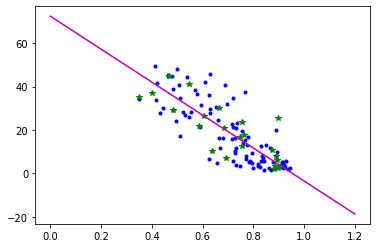

In [731]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [732]:
filldata(whole_data,m,b,34)

In [733]:
crossVal(X,y) 

,train_1,test_1,train_2,test_2
0,0.625076,0.743104,0.625076,0.743104
1,0.664412,0.603516,0.664412,0.603516
2,0.669561,0.586908,0.669561,0.586908
3,0.638844,0.723781,0.638844,0.723781
4,0.677334,0.522061,0.677334,0.522061
Mean,0.655045,0.635874,0.655045,0.635874
Standard Deviation,0.019778,0.084409,0.019778,0.084409


In [734]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.700602,0.709832,0.700602,0.709832
33,0.620797,0.511345,0.620797,0.511345
34,0.665131,0.624667,0.665131,0.624667
35,0.692342,0.686297,0.692342,0.686297
36,0.599805,0.714006,0.599805,0.714006
37,0.760684,0.470766,0.760684,0.470766
38,0.563407,0.351575,0.563407,0.351575
39,0.659522,0.612336,0.659522,0.612336
Mean,0.705988,0.575805,0.705988,0.575805
Standard Deviation,0.026712,0.085608,0.026712,0.085608


### Inequality-Adjusted Education Index:

In [735]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Education Index")

-0.35202286655589665 1.2735289138882815


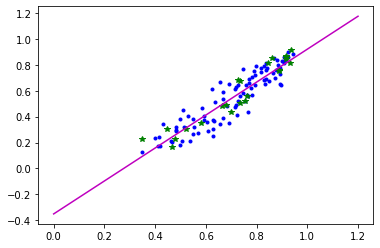

In [736]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [737]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8382532170023625
The testing R2: 0.9097079583441764


In [738]:
filldata(whole_data,m,b,35)

In [739]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.862325,0.814345,0.862325,0.814345
1,0.845089,0.875584,0.845089,0.875584
2,0.863798,0.815872,0.863798,0.815872
3,0.860526,0.821876,0.860526,0.821876
4,0.856627,0.841167,0.856627,0.841167
Mean,0.857673,0.833769,0.857673,0.833769
Standard Deviation,0.006734,0.022988,0.006734,0.022988


In [740]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.804349,0.852613,0.804349,0.852613
33,0.823869,0.773848,0.823869,0.773848
34,0.858017,0.873264,0.858017,0.873264
35,0.887377,0.775305,0.887377,0.775305
36,0.875733,0.856544,0.875733,0.856544
37,0.855916,0.897854,0.855916,0.897854
38,0.874972,0.771229,0.874972,0.771229
39,0.848645,0.855036,0.848645,0.855036
Mean,0.850783,0.858342,0.850783,0.858342
Standard Deviation,0.002293,0.038059,0.002293,0.038059


### Inequality-Adjusted Income Index:

In [741]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Income Index")

-0.15906812100342804 0.9875689579319901


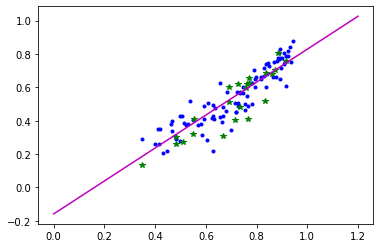

In [742]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [743]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.823325415765624
The testing R2: 0.7835822783414207


In [744]:
filldata(whole_data,m,b,37)

In [745]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.808243,0.845224,0.808243,0.845224
1,0.837608,0.708297,0.837608,0.708297
2,0.802222,0.866602,0.802222,0.866602
3,0.806196,0.861743,0.806196,0.861743
4,0.830717,0.754488,0.830717,0.754488
Mean,0.816997,0.807271,0.816997,0.807271
Standard Deviation,0.014316,0.064046,0.014316,0.064046


In [746]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.834787,0.721347,0.834787,0.721347
33,0.800142,0.781480,0.800142,0.781480
34,0.852132,0.843492,0.852132,0.843492
35,0.843101,0.830157,0.843101,0.830157
36,0.827908,0.801380,0.827908,0.801380
37,0.837782,0.842091,0.837782,0.842091
38,0.798436,0.682472,0.798436,0.682472
39,0.817639,0.764574,0.817639,0.764574
Mean,0.813746,0.708305,0.813746,0.708305
Standard Deviation,0.020835,0.187477,0.020835,0.187477


### Inequality-adjusted HDI (IHDI):

In [747]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality-adjusted HDI (IHDI)")

-0.2530650251447015 1.1735639553663035


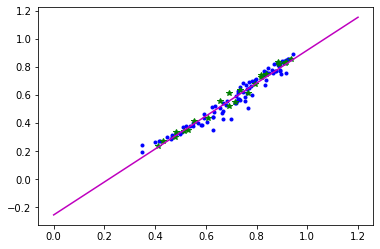

In [748]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [749]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.948055763042972
The testing R2: 0.9804796976244854


In [750]:
filldata(whole_data,m,b,28)

In [751]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.953688,0.958604,0.953688,0.958604
1,0.951196,0.969479,0.951196,0.969479
2,0.952241,0.969527,0.952241,0.969527
3,0.958415,0.932421,0.958415,0.932421
4,0.962438,0.914929,0.962438,0.914929
Mean,0.955595,0.948992,0.955595,0.948992
Standard Deviation,0.004219,0.021765,0.004219,0.021765


In [752]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.946644,0.948286,0.946644,0.948286
33,0.963020,0.911596,0.963020,0.911596
34,0.972200,0.940485,0.972200,0.940485
35,0.961915,0.940105,0.961915,0.940105
36,0.963988,0.962936,0.963988,0.962936
37,0.961238,0.926335,0.961238,0.926335
38,0.945258,0.969052,0.945258,0.969052
39,0.974475,0.970095,0.974475,0.970095
Mean,0.957501,0.940953,0.957501,0.940953
Standard Deviation,0.008643,0.053288,0.008643,0.053288


### IHDI Loss Percent:

In [753]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","IHDI Loss Percent")

62.77897151031554 -59.69874916593561


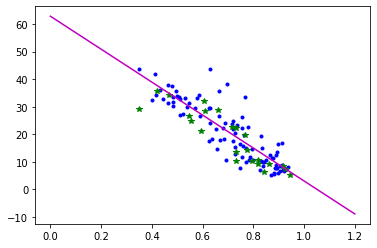

In [754]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [755]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.7560551472502122
The testing R2: 0.7470656557731947


In [756]:
filldata(whole_data,m,b,29)

In [757]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.741067,0.846529,0.741067,0.846529
1,0.791006,0.625879,0.791006,0.625879
2,0.761767,0.733213,0.761767,0.733213
3,0.735191,0.853263,0.735191,0.853263
4,0.768379,0.718990,0.768379,0.718990
Mean,0.759482,0.755575,0.759482,0.755575
Standard Deviation,0.020037,0.085411,0.020037,0.085411


In [758]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.758911,0.736434,0.758911,0.736434
33,0.717560,0.816658,0.717560,0.816658
34,0.749699,0.652905,0.749699,0.652905
35,0.755946,0.661927,0.755946,0.661927
36,0.711226,0.836731,0.711226,0.836731
37,0.689363,0.759608,0.689363,0.759608
38,0.824736,0.786433,0.824736,0.786433
39,0.760403,0.682472,0.760403,0.682472
Mean,0.798307,0.724401,0.798307,0.724401
Standard Deviation,0.053975,0.144433,0.053975,0.144433


### Coefficient of Human Inequality:

In [759]:
X_test, y_test, X_train, y_train,X, y = createTestTrain(df,"Human Development Index (2014)","Coefficient of Human Inequality")

62.25470817710115 -59.743334269260515


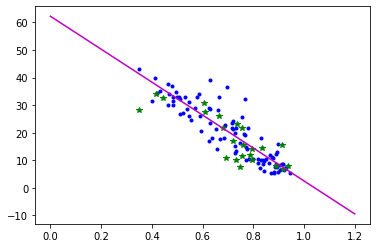

In [760]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [761]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8007360547114992
The testing R2: 0.5920707968227898


In [762]:
filldata(whole_data,m,b,31)

In [763]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.773350,0.765955,0.773350,0.765955
1,0.789362,0.629462,0.789362,0.629462
2,0.765622,0.754864,0.765622,0.754864
3,0.804800,0.601408,0.804800,0.601408
4,0.739860,0.885016,0.739860,0.885016
Mean,0.774599,0.727341,0.774599,0.727341
Standard Deviation,0.021995,0.102518,0.021995,0.102518


In [764]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.736702,0.814470,0.736702,0.814470
33,0.761257,0.753296,0.761257,0.753296
34,0.794890,0.700456,0.794890,0.700456
35,0.828637,0.824734,0.828637,0.824734
36,0.792852,0.702555,0.792852,0.702555
37,0.861624,0.734670,0.861624,0.734670
38,0.816510,0.808199,0.816510,0.808199
39,0.790858,0.728381,0.790858,0.728381
Mean,0.761555,0.754381,0.761555,0.754381
Standard Deviation,0.053925,0.116223,0.053925,0.116223


### Inequality in Life Expectancy: 

In [765]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Life Expectancy")

70.45371937204732 -76.70492192339516


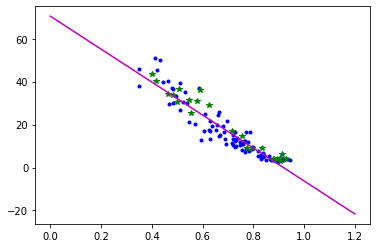

In [766]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [767]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8733431599825356
The testing R2: 0.9231429123882771


In [768]:
filldata(whole_data,m,b,31)

In [769]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.888543,0.887155,0.888543,0.887155
1,0.882157,0.911815,0.882157,0.911815
2,0.879691,0.904570,0.879691,0.904570
3,0.889195,0.885899,0.889195,0.885899
4,0.901123,0.817990,0.901123,0.817990
Mean,0.888142,0.881486,0.888142,0.881486
Standard Deviation,0.007443,0.033275,0.007443,0.033275


In [770]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.897259,0.858705,0.897259,0.858705
33,0.899884,0.917250,0.899884,0.917250
34,0.874667,0.876518,0.874667,0.876518
35,0.885460,0.919377,0.885460,0.919377
36,0.901788,0.901878,0.901788,0.901878
37,0.886189,0.878971,0.886189,0.878971
38,0.902129,0.828934,0.902129,0.828934
39,0.905297,0.941740,0.905297,0.941740
Mean,0.895600,0.857712,0.895600,0.857712
Standard Deviation,0.013071,0.062322,0.013071,0.062322


## mpi_data
#### We need to find regression models for:
- Population Below National Poverty Line
- Population Below $1.25 per Day

In [771]:
for column in mpi_data.columns:
    df = mpi_data[pd.notna(mpi_data.loc[:,column])]
    df = df.dropna()

In [772]:
mpi_data.columns.get_loc("Population Below $1.25 per Day")

11

### Population Below National Poverty Line

In [773]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below National Poverty Line")

23.915689856268916 66.29447164008472


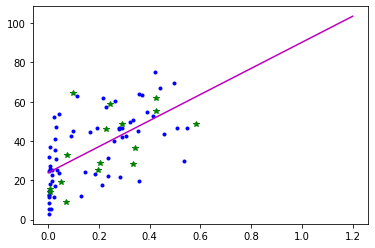

In [774]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [775]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.37822293278215247
The testing R2: 0.3549012400036653


In [776]:
filldatampi(mpi_data, m, b, 11)

In [777]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.383716,0.302837,0.383716,0.302837
1,0.400626,0.197716,0.400626,0.197716
2,0.299290,0.744779,0.299290,0.744779
3,0.414352,0.255457,0.414352,0.255457
4,0.382290,0.345043,0.382290,0.345043
Mean,0.376055,0.369166,0.376055,0.369166
Standard Deviation,0.040152,0.194109,0.040152,0.194109


In [778]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.255318,0.456690,0.255318,0.456690
33,0.223576,0.402594,0.223576,0.402594
34,0.348677,0.327531,0.348677,0.327531
35,0.386913,0.495351,0.386913,0.495351
36,0.391246,0.517931,0.391246,0.517931
37,0.364232,0.235029,0.364232,0.235029
38,0.417090,0.463909,0.417090,0.463909
39,0.363671,0.600573,0.363671,0.600573
Mean,0.381390,0.292674,0.381390,0.292674
Standard Deviation,0.066242,0.230400,0.066242,0.230400


### Population Below 1.25 per Day:

In [779]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below $1.25 per Day")

5.031219561405653 121.76496176152962


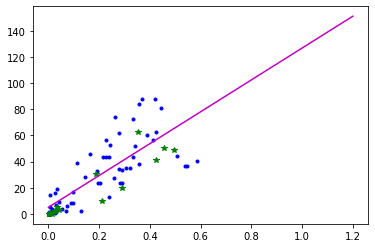

In [780]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [781]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.6194138498164588
The testing R2: 0.7252805812161613


In [783]:
filldatampi(mpi_data, m, b, 11)

In [784]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.652590,0.420499,0.652590,0.420499
1,0.634007,0.727385,0.634007,0.727385
2,0.672493,0.573702,0.672493,0.573702
3,0.608370,0.770596,0.608370,0.770596
4,0.682419,0.302252,0.682419,0.302252
Mean,0.649976,0.558887,0.649976,0.558887
Standard Deviation,0.026655,0.178014,0.026655,0.178014


In [785]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.632783,0.649571,0.632783,0.649571
33,0.640575,0.541799,0.640575,0.541799
34,0.629665,0.529791,0.629665,0.529791
35,0.704679,0.523652,0.704679,0.523652
36,0.698858,0.873177,0.698858,0.873177
37,0.696573,0.635604,0.696573,0.635604
38,0.632402,0.552448,0.632402,0.552448
39,0.607990,0.510426,0.607990,0.510426
Mean,0.657088,0.571352,0.657088,0.571352
Standard Deviation,0.030282,0.096483,0.030282,0.096483


In [786]:
whole_data = whole_data.dropna()

In [787]:
mpi_data =mpi_data.dropna()


In [788]:
wd_set =set(whole_data.iloc[:,1].to_list())
mpi_set=set(mpi_data.iloc[:,0].to_list())

{'Egypt', 'Dominican Republic', 'Nigeria', 'Mali', 'Kyrgyzstan', 'Syrian Arab Republic', 'Ukraine', 'Montenegro', 'Kazakhstan', 'Madagascar', 'The former Yugoslav Republic of Macedonia', 'Morocco', 'Benin', 'Belarus', 'Cambodia', 'Sierra Leone', 'Chad', 'Niger', 'Honduras', 'Jamaica', 'Central African Republic', 'Indonesia', 'Tanzania (United Republic of)', "Côte d'Ivoire", 'Ecuador', 'Burundi', 'Ghana', 'Comoros', 'Senegal', 'Tajikistan', 'Bhutan', 'Rwanda', 'Peru', 'Congo', 'Nicaragua', 'Nepal', 'Guinea', 'Lesotho', 'Albania', 'India', 'Georgia', 'Azerbaijan', 'Philippines', 'Congo (Democratic Republic of the)', 'Sudan', 'Guinea-Bissau', 'Namibia', 'Serbia', 'Bosnia and Herzegovina', 'Timor-Leste', 'Cameroon', 'Tunisia', 'Togo', 'Armenia', 'Afghanistan', 'Ethiopia', 'Pakistan', 'Liberia', 'Mozambique', 'Uganda', 'Bangladesh', 'Kenya', 'Palestine, State of', 'Malawi', 'Sao Tome and Principe', 'Viet Nam', 'Gabon', 'Mauritania', 'Zambia', 'South Africa', 'Jordan', 'Burkina Faso', 'Colom

In [789]:
new_countries =mpi_set.intersection(wd_set.intersection(mpi_set))

In [790]:
keep = list(new_countries)
new_whole_data = whole_data
for i in whole_data.index:
    if not whole_data.loc[i,"Country"] in keep:
        new_whole_data = new_whole_data.drop(i, axis=0)

In [791]:
new_mpi_data = mpi_data
for i in mpi_data.index:
    if not mpi_data.loc[i,"Country"] in keep:
        new_mpi_data = new_mpi_data.drop(i, axis=0)

In [812]:
new_whole_data = new_whole_data.sort_values('Country').reset_index()
new_whole_data.head()

,level_0,index,GDI Rank,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),...,Inequality-Adjusted Education Index,Inequality in Income,Inequality-Adjusted Income Index,Human Development Index (1990),Human Development Index (2000),Human Development Index (2010),Human Development Index (2011),Human Development Index (2012),Human Development Index (2013),Human Development Index (2014)
0,0,170,171.0,Afghanistan,0.6,0.328,0.546,61.6,59.2,7.2,...,0.202,10.8,0.396,0.297,0.334,0.448,0.456,0.463,0.464,0.465
1,1,84,85.0,Albania,0.948,0.711,0.75,80.4,75.4,11.9,...,0.561,18.3,0.567,0.624,0.656,0.722,0.728,0.729,0.732,0.733
2,2,85,85.0,Armenia,1.008,0.734,0.728,78.6,70.9,13.6,...,0.679,13.9,0.572,0.632,0.648,0.721,0.723,0.728,0.731,0.733
3,3,141,142.0,Bangladesh,0.917,0.541,0.59,72.9,70.4,10.3,...,0.274,28.3,0.375,0.386,0.468,0.546,0.559,0.563,0.567,0.570
4,4,165,166.0,Benin,0.823,0.431,0.524,61,58.1,9.4,...,0.23,29.4,0.306,0.344,0.392,0.468,0.473,0.475,0.477,0.480


In [813]:
new_mpi_data = new_mpi_data.sort_values('Country').reset_index()
new_mpi_data.head()

,index,Country,"Multidimensional Poverty Index (MPI, HDRO)",MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,0,Afghanistan,0.293,58.8,0.353,66.2,17116,49.9,45.6,19.2,35.2,35.8,3922.03
1,1,Albania,0.005,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,3,Armenia,0.002,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32,1.8
3,5,Bangladesh,0.237,49.5,0.253,51.3,75610,47.8,28.4,26.6,44.9,31.5,43.3
4,9,Benin,0.343,64.2,0.307,62.2,6455,53.3,33.1,24.8,42.1,36.2,51.6


In [814]:
complete_data = pd.concat([new_whole_data, new_mpi_data], axis = 1)

In [822]:
complete_data = complete_data.drop(complete_data.columns[0:2],axis=1)

In [823]:
complete_data = complete_data.loc[:,~complete_data.columns.duplicated()]

In [824]:
complete_data.head()

,GDI Rank,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),Expected Years of Education (Male),Mean Years of Education (Female),...,MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,171.0,Afghanistan,0.6,0.328,0.546,61.6,59.2,7.2,11.3,1.2,...,58.8,0.353,66.2,17116,49.9,45.6,19.2,35.2,35.8,3922.03
1,85.0,Albania,0.948,0.711,0.75,80.4,75.4,11.9,11.8,8.9,...,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,85.0,Armenia,1.008,0.734,0.728,78.6,70.9,13.6,11.2,10.8,...,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32,1.8
3,142.0,Bangladesh,0.917,0.541,0.59,72.9,70.4,10.3,9.7,4.5,...,49.5,0.253,51.3,75610,47.8,28.4,26.6,44.9,31.5,43.3
4,166.0,Benin,0.823,0.431,0.524,61,58.1,9.4,12.7,2.1,...,64.2,0.307,62.2,6455,53.3,33.1,24.8,42.1,36.2,51.6
